In [ ]:
!uv pip install numpy matplotlib torch

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def f(x):
    return 4*x**2 - 2 * x + 3

In [9]:
xs = np.arange(-5, 5, 0.5)
ys = f(xs)
ys

array([113.,  93.,  75.,  59.,  45.,  33.,  23.,  15.,   9.,   5.,   3.,
         3.,   5.,   9.,  15.,  23.,  33.,  45.,  59.,  75.])

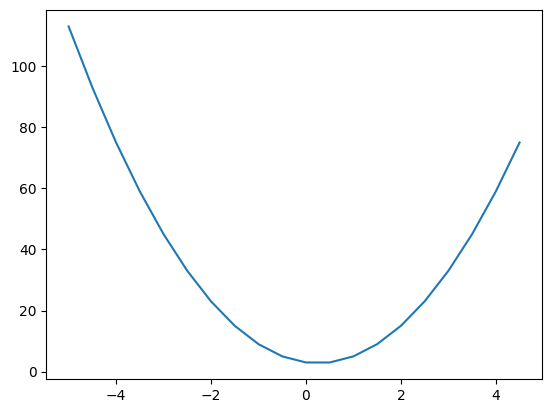

In [10]:
plt.plot(xs, ys)

In [15]:
h = 0.0001
x = 0
(f(x + h) - f(x)) / h

-1.9996000000022107

In [1173]:
from typing import Optional

class Value:
    def __init__(self, data, prev=(), op:Optional[str]=None):
        self.data = data
        self.prev = prev
        self.op = op
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = backward
        
        return out

    def __radd__(self, other):
        return self + other

    def __neg__():
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")    
        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = backward
        
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f"**{other}")
        def backward():
            self.grad += other * self.data**(other-1) * out.grad
            
        out._backward = backward
        
        return out
        
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        
        out = Value(t, (self,), "tanh")
        def backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")
        def backward():
            self.grad += out.data * out.grad
            
        out._backward = backward
        
        return out

    def backward(self):
        # topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    # def backward(self):
    #     topo = []
    #     visited = set()
    #     stack = [self] # Initialize stack with the final output node (self)
    
    #     while stack:
    #         v = stack.pop()
            
    #         if v not in visited:
    #             visited.add(v)
                
    #             # 1. Ensure the node is processed later:
    #             # Push 'v' back onto the stack. This guarantees it will be processed 
    #             # *after* its children have been placed in the topo list.
    #             stack.append(v)
                
    #             # 2. Process all predecessors (parents) first:
    #             # Push all children (predecessors) onto the stack. 
    #             # Since the stack is LIFO, they will be popped and processed next.
    #             for child in v.prev:
    #                 if child not in visited:
    #                     stack.append(child)
            
    #         else:
    #             # 3. Append to Topo List:
    #             # When 'v' is popped a second time (because it's already in visited), 
    #             # it means all of its predecessors (children) have been fully explored.
    #             # It is now safe to add it to the topological order list.
    #             topo.append(v)
        
    #     # --- Backpropagation ---
    #     # The 'topo' list is a reverse topological sort. We iterate it backwards 
    #     # to get the correct forward order for backprop (input-to-output).
    #     self.grad = 1.0
    #     for node in reversed(topo):
    #         node._backward()

In [143]:
# inputs
x1 = Value(2.0)
x2 = Value(0.0)

# weights
w1 = Value(-3.0)
w2 = Value(1.0)

# bias on the neuron
b = Value(6.8813735870195432)

x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b

# orig
# o = n.tanh()

# new
e = (2*n).exp()
o = (e - 1) / (e + 1)

o.backward()

print(f"x1={x1.grad}, x2={x2.grad}, w1={w1.grad}, w2={w2.grad}")

x1=-1.5, x2=0.5, w1=1.0, w2=0.0


## Pytorch equivalent

In [147]:
import torch
# inputs
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True

# weights
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double();  w2.requires_grad = True

b = torch.tensor([6.8813735870195432]).double();  b.requires_grad = True

x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b

# orig
o = n.tanh()

print(o.data.item())
print('----')
o.backward()
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())


0.7071066904050358
----
-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0


In [1164]:
import random

class Neuron:
    def __init__(self, nin):
        self._weights = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self._bias = Value(random.uniform(-1, 1))

    def __call__(self, x):
        zipped = zip(x, self._weights)
        lis = [xi*wi for xi,wi in zip(x, self._weights)]
        su = sum(lis)
        activation = su + self._bias

        # return activation.relu()
        return activation.tanh()

    def parameters(self):
        return self._weights + [self._bias]

class Layer:
    def __init__(self, n_inputs, n_neurons):
        self._neurons = [Neuron(n_inputs) for _ in range(n_neurons)]

    def __call__(self, x):
        return [neuron(x) for neuron in self._neurons]

    def parameters(self):
        params = []
        for neuron in self._neurons:
            params.extend(neuron.parameters())

        return params

# Multi-layer-perceptron
class MLP:
    def __init__(self, n_inputs, n_outputs):
        sz = [n_inputs] + n_outputs
        self._layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outputs))]

    def __call__(self, x):
        for layer in self._layers:
            x = layer(x)

        return x[0] if len(x) == 1 else x

    def parameters(self):
        params = []
        for layer in self._layers:
            params.extend(layer.parameters())

        return params

In [1214]:
network = MLP(3, [6, 4, 3, 1])

In [1215]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
    [2.0, 3.0, -1.5],
    # [2.0, 3.5, -1.0],
    # [2.0, -3.5, -1.0],
    # [2.0, -3.0, -1.0],
    # [0.5, -0.5, -7.5],
    # [4, -10, 7],
    # [9.5, -10, 7],
    # [9.0, -10, 7],
]

ys = [1.0, -1.0, -1.0, 1.0]
ys = [1.0, -1.0, -1.0, 1.0, -1.0]
# ys = [1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0]

In [1204]:
import numpy as np
import json

def generate_pattern_data_rounded(num_entries=5000, x_range=(-10.0, 10.0), n_range=(-5, 5)):
    """
    Generates training data where x1, x2, x3 are rounded to the nearest 0.5 step.
    Rule: y = 1.0 if (x1 + x2 - x3) is an integer, y = -1.0 otherwise.
    
    Args:
        num_entries (int): The number of data points to generate.
        x_range (tuple): (min, max) for the initial x1 and x2 uniform distribution.
        n_range (tuple): (min, max) for the random integer N used in calculation.

    Returns:
        xs (list of lists): The features (x1, x2, x3) rounded to 0.5 steps.
        ys (list of floats): The labels (1.0 or -1.0).
    """
    
    # --- 1. Generate and Round x1 and x2 to the nearest 0.5 step ---
    raw_x1 = np.random.uniform(low=x_range[0], high=x_range[1], size=num_entries)
    raw_x2 = np.random.uniform(low=x_range[0], high=x_range[1], size=num_entries)
    
    # Rounding to the nearest 0.5 step: round(x * 2) / 2
    x1 = np.round(raw_x1 * 2) / 2
    x2 = np.round(raw_x2 * 2) / 2
    
    # Determine which entries should result in y=1 (integer) and y=-1 (non-integer)
    is_integer = np.random.choice([True, False], size=num_entries)

    # Calculate the intermediate sum S = x1 + x2
    S = x1 + x2
    
    # --- 2. Calculate x3 such that the pattern is met, and then round x3 ---
    
    # Prepare the x3 array
    x3 = np.empty(num_entries)
    
    # *** Case: y = 1.0 (S - x3 must be an integer) ***
    # We enforce x3 = S - N, where N is a random integer.
    N_integer = np.random.randint(low=n_range[0], high=n_range[1] + 1, size=np.sum(is_integer))
    x3_int_raw = S[is_integer] - N_integer
    x3[is_integer] = np.round(x3_int_raw * 2) / 2 # Round x3 to 0.5 step

    # *** Case: y = -1.0 (S - x3 must be a non-integer) ***
    # We enforce x3 = S - (N + 0.5), where N is an integer.
    N_non_integer = np.random.randint(low=n_range[0], high=n_range[1] + 1, size=np.sum(~is_integer))
    
    # Use a fixed 0.5 offset to guarantee a non-integer result (e.g., x.0 + x.5 = x.5)
    x3_non_int_raw = S[~is_integer] - (N_non_integer + 0.5)
    x3[~is_integer] = np.round(x3_non_int_raw * 2) / 2 # Round x3 to 0.5 step
    
    # --- 3. Determine Final Label (Y) based on Rounded Inputs ---
    # Since we rounded x3, the original intent might have changed (e.g., a non-integer
    # result might have been rounded to an integer result). We must rely on the
    # final calculated S - x3 value to set the true label.
    S_final = x1 + x2 - x3
    
    # Check if S_final is an integer (within a small tolerance)
    final_y = np.where(np.abs(S_final - np.round(S_final)) < 1e-6, 1.0, -1.0)
    
    # Combine x1, x2, x3 into the final 'xs' array
    xs = np.vstack((x1, x2, x3)).T.tolist()
    
    return xs, final_y.tolist()

# --- Execution ---
xs, ys = generate_pattern_data_rounded(num_entries=100)

In [1218]:
for k in range(10000):
    # Forward pass
    ypred = [network(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip (ys, ypred))

    if loss.data < 0.01:
        break
    
    # Backward pass
    for p in network.parameters():
        p.grad = 0.0
    loss.backward()

    for p in network.parameters():
        p.data += -0.1 * p.grad

print(k, loss.data)

0 0.009728273024250046


In [1219]:
network([0, 0, -0.5])

Value(data=0.9729300648438014)